In [1]:

from datetime import datetime

import torch
from torch.utils.data import DataLoader

from datasets.LabeledImageDataset import LabeledImageDataset
from models.resnet import Resnet50Model, Resnet18Model
from train import train_classifier
from utils import plot_model_metrics, oversample_dataset
from utils import reduce_dataset, split_dataset, undersample_dataset
from torchvision.transforms import v2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 128
dataset = LabeledImageDataset("data/candidates")
dataset = reduce_dataset(dataset, discard_ratio=0.0)
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.7)
train_dataset = oversample_dataset(undersample_dataset(train_dataset, target_size=2000),
                                   augment_Size=1800,
                                   transforms=v2.Compose([
                                       v2.ToImage(),
                                       # v2.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
                                       v2.RandomHorizontalFlip(p=0.5),
                                       v2.RandomVerticalFlip(p=0.5),
                                       v2.RandomRotation(degrees=30),
                                       # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                       # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                       v2.ToDtype(torch.float32, scale=True),
                                       v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                   ]))  #undersample_dataset(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, )

model = Resnet18Model(hidden_layers=2, units_per_layer=2048, dropout=0.4)

print(f"Dataset: {len(train_dataset):,} training, {len(test_dataset):,} testing")


Device: cuda:0
Dataset: 3,948 training, 2,378 testing


In [2]:
print(model)

Resnet50Model(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [3]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2024-11-13T21:51:05.571566


In [ ]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, test_loader, device,
                                        learning_rate=0.0001,
                                        max_epochs=50,
                                        checkpoint_every=1,
                                        eval_every=1)


Epoch 1 training: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


Train: 1/50: loss:0.26502911422041153


Epoch 1 testing: 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]


Test: 1/50: loss:0.19266118187653392, accuracy:0.9733841571834994, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, epoch:0


Epoch 2 training: 100%|██████████| 31/31 [00:25<00:00,  1.23it/s]


Train: 2/50: loss:0.1363541803533031


Epoch 2 testing: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


Test: 2/50: loss:0.13290579930732124, accuracy:0.9733841571834994, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, epoch:1


Epoch 3 training:  48%|████▊     | 15/31 [00:12<00:12,  1.26it/s]

Training ends 2024-11-13T20:27:07.760803
Test accuracy: 0.971875
Test precision: 0.1
Test recall: 0.05833333333333333
Test f1: 0.07333333333333333
Test mcc: 0.06869824555327833


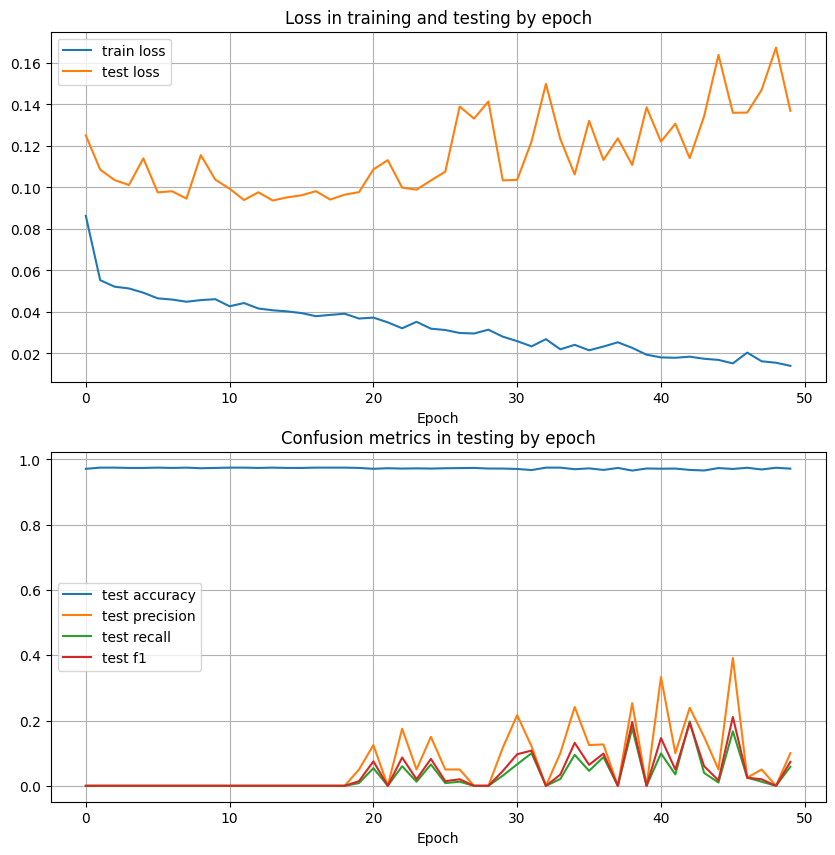

In [6]:

print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)